In [1]:
import torch
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import cv2
import os
import copy

c:\Users\ammar\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\ammar\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\ammar\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
with open('./~/training-runs/00002-styledata-auto1/network-snapshot-000800.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].cuda()  # torch.nn.Module
z = torch.randn([1, G.z_dim]).cuda()    # latent codes
c = None                                # class labels (not used in this example)
img = G(z, c)                           # NCHW, float32, dynamic range [-1, +1]

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


In [3]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    print(inp.size())
    inp = inp.detach().cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(16, 16))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

torch.Size([3, 256, 256])


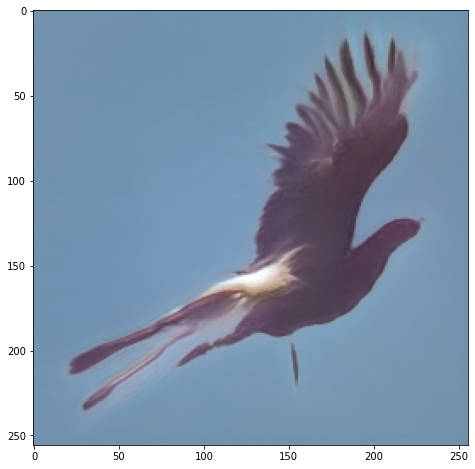

In [251]:
sitting = torch.randn([1, 512]).cuda()
img = G(sitting, c)[0]
imshow(img)
# np.save('sitting', sitting.cpu().numpy())

torch.Size([3, 256, 256])


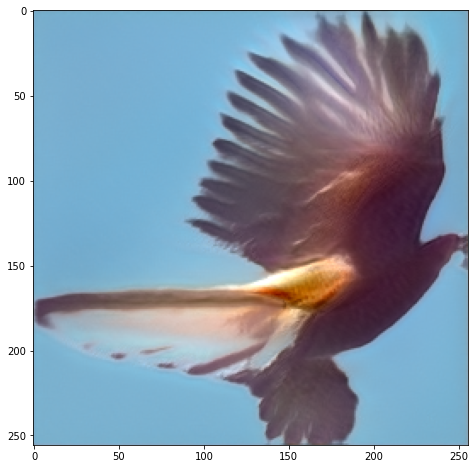

In [244]:
flying = torch.randn([1, 512]).cuda()
w = G.mapping(flying, c)
img = G.synthesis(w, noise_mode='random')[0]
imshow(img)
# np.savez('flying_projected6', w=w.cpu().numpy())

torch.Size([3, 256, 256])


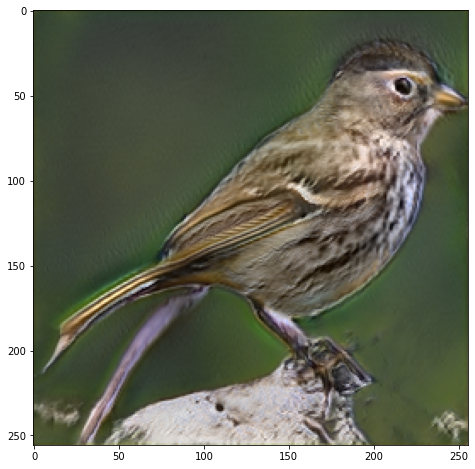

In [225]:
one = torch.randn([1, 512]).cuda()
img = G(one, c)[0]
imshow(img)

In [241]:
two = 0.9 * two + 0.5 * one

torch.Size([3, 256, 256])


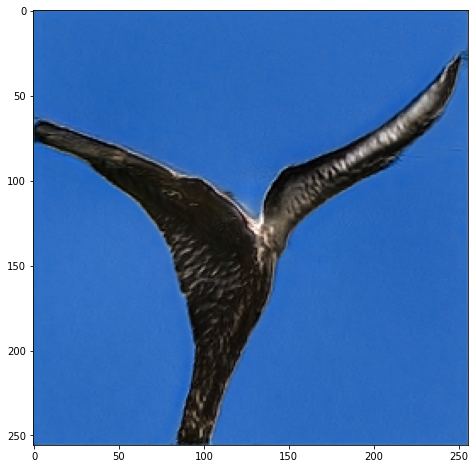

In [299]:
two = 0.9 * torch.randn([1, 512]).cuda() + 0.5 * one + 1.5 * sitting
img = G(0.9 * two + 0.5 * one, c)[0]
imshow(img)

torch.Size([3, 256, 256])


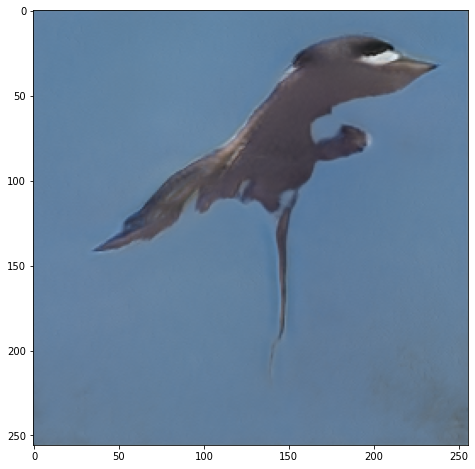

In [242]:
three = 0.5 * torch.randn([1, 512]).cuda() + 0.9 * two
img = G(three, c)[0]
imshow(img)

torch.Size([3, 256, 256])


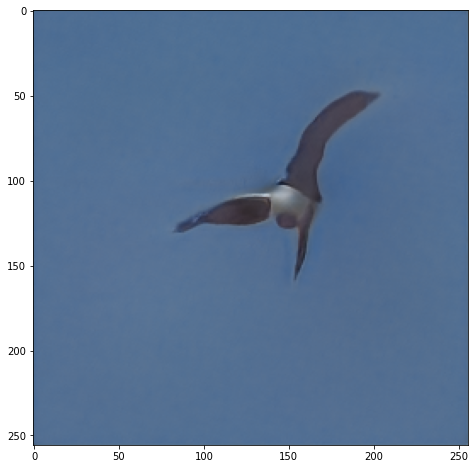

In [244]:
four = 0.5 * torch.randn([1, 512]).cuda() + 0.9 * three
img = G(four, c)[0]
imshow(img)

torch.Size([3, 256, 256])


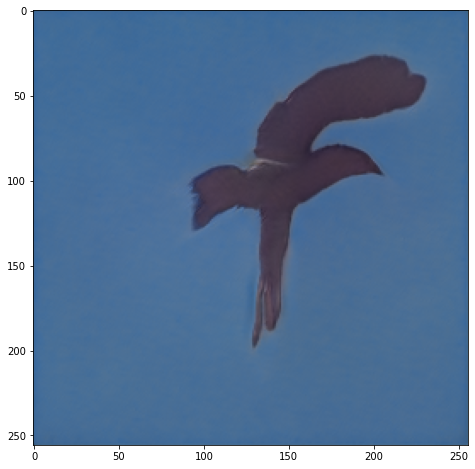

In [246]:
five = 0.5 * torch.randn([1, 512]).cuda() + 0.9 * four
img = G(five, c)[0]
imshow(img)

In [8]:
def slide(bird1, bird2, step=8):
    frames = []
    for i in range(0, step):
        frames.append((bird1 * (step - i) / step + bird2 * i / step)[0]) # 

    return frames

def multi_slide(vectors):
    assert len(vectors) >= 2

    animation = []

    for i in range(0, len(vectors) - 1):
        animation += (slide(vectors[i], vectors[i + 1]))

    return animation

In [268]:
# birds = multi_slide([sitting, flying, sitting, flying, sitting, flying, sitting, flying, sitting, flying, sitting, flying])
# birds = multi_slide([flying, sitting])
# birds = multi_slide([one, two, three, four, five, five, four, three, two, one])
birds = slide(sitting, flying)

dataloader = torch.utils.data.DataLoader(birds, batch_size=16, shuffle=False)

In [269]:
birds[0].shape

torch.Size([512])

In [270]:
output = []

for data in dataloader:
    outs = G(data.squeeze(), None)

    for img in outs:
        output.append(img)

torch.Size([3, 260, 2066])


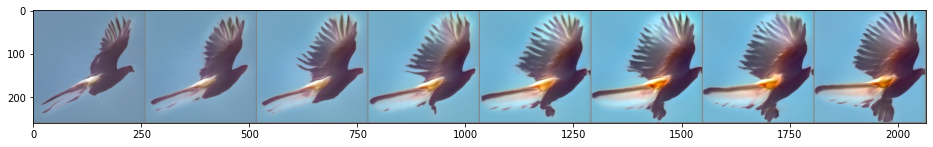

In [273]:
imshow(torchvision.utils.make_grid(output))

In [7]:

# imshow(torchvision.utils.make_grid(output))

import cv2

def make_animation(arr, save_name='bird_animation_stages.avi', frame_rate=24):
    frames = []
    for inp in arr:
        inp = inp.squeeze().detach().cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)* 255
        inp = cv2.cvtColor(inp.astype(np.uint8), cv2.COLOR_BGR2RGB)
        # cv2.imwrite('test.png', inp)
        frames.append(inp)
    print(len(frames))

    out = cv2.VideoWriter(save_name,cv2.VideoWriter_fourcc(*'DIVX'), frame_rate, (256, 256))
 
    for i in range(len(frames)):
        out.write(frames[i])
    out.release()
    
# make_animation(output)

In [6]:
def project_img(source_dir, count=0):

    import os

    network_path = './~/training-runs/00002-styledata-auto1/network-snapshot-000800.pkl'
    output_dir = './targets'

    command = f'python projector.py --network {network_path} --target {source_dir} --outdir {output_dir}/{count}'

    print(command)
    os.system(command)

def load_w_vector(path):
    npz_file = np.load(path)
    vector = npz_file.f.w
    npz_file.close()

    vector = torch.from_numpy(vector).cuda()

    return vector

In [4]:
for i, filename in enumerate(os.listdir('targets')):
    dir = f'targets/{filename}'
    project_img(dir, i)

python projector.py --network ./~/training-runs/00002-styledata-auto1/network-snapshot-000800.pkl --target targets/frame_0000.jpg --outdir ./targets/0
python projector.py --network ./~/training-runs/00002-styledata-auto1/network-snapshot-000800.pkl --target targets/frame_0001.jpg --outdir ./targets/1
python projector.py --network ./~/training-runs/00002-styledata-auto1/network-snapshot-000800.pkl --target targets/frame_0002.jpg --outdir ./targets/2
python projector.py --network ./~/training-runs/00002-styledata-auto1/network-snapshot-000800.pkl --target targets/frame_0003.jpg --outdir ./targets/3
python projector.py --network ./~/training-runs/00002-styledata-auto1/network-snapshot-000800.pkl --target targets/frame_0004.jpg --outdir ./targets/4
python projector.py --network ./~/training-runs/00002-styledata-auto1/network-snapshot-000800.pkl --target targets/frame_0011.jpg --outdir ./targets/5
python projector.py --network ./~/training-runs/00002-styledata-auto1/network-snapshot-000800.

In [5]:
def deepfake(projected_dir='./flying_projected6.npz', col_styles=range(0, 7)):

    # Load the w vector of the source image
    projected = load_w_vector(projected_dir)
    # rand_z = torch.rand([1, G.z_dim]).cuda()
    # projected = G.mapping(rand_z, c=None)
    # imshow(G.synthesis(projected, noise_mode='random')[0])



    # Get the array of w vectors for target frames
    w_targets = []
    for i in range(0, 14):
        w_target = load_w_vector(f'targets/{i}/projected_w.npz')
        w_targets.append(w_target)
    w_targets += w_targets[6:]


    # Generate random vector and get it's styles
    # rand_z = torch.rand([5, G.z_dim]).cuda()
    # w_targets = G.mapping(rand_z, c=None)

    # Style mix
    transformed = [projected]
    for w in w_targets:
        w_s = copy.deepcopy(projected) # w source vector
        # print(w.shape, w_s.shape)
        w_s[0][col_styles] = w[0][col_styles]
        w_s[0][11] *= 1.5

        transformed.append(w_s)

        # out = G.synthesis(w_s)
        # transformed.append(out[0])

    all_w = multi_slide(transformed)
    dataloader = torch.utils.data.DataLoader(all_w, batch_size=16, shuffle=False)
    
    # Get the actual images
    output = []

    for data in dataloader:
        outs = G.synthesis(data, noise_mode='random')

        for img in outs:
            output.append(img)

    make_animation(output, save_name="demo.mp4", frame_rate=24)


    # imshow(torchvision.utils.make_grid(transformed))
    # imshow(output[0])


In [200]:
rand_z = None
projected = None
all_w = None
deepfake('./good_birds/2/projected_w.npz')

220


In [1]:
# sitting = torch.randn([8, 512]).cuda()
w_1 = G.mapping(sitting, c)
print(w_1.shape)
img = G.synthesis(w_1)

stacked = [torchvision.utils.make_grid(img)]
# for i in range(1, 8):
#     img[0] = img[i]
#     stacked.append(torchvision.utils.make_grid(img))
img = torch.cat(stacked, dim=1)

# imshow(torchvision.utils.make_grid(img))
imshow(img)

NameError: name 'G' is not defined

torch.Size([1, 14, 512])
torch.Size([3, 256, 256])


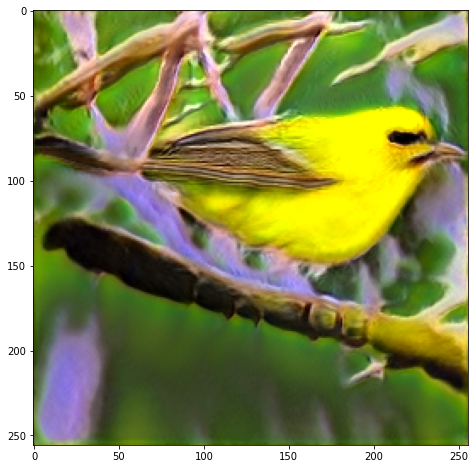

In [102]:
standing = torch.randn([1, 512]).cuda()
w_2 = G.mapping(standing, c)
print(w_2.shape)
# w_2[:, range(7)] = w_1[:, range(7)]
img = G.synthesis(w_2)[0]
imshow(img)

In [87]:
def cosine_similarity(w1, w2):
    w1 = w1[0]
    w2 = w2[0]
    # w1 = w1[6:9]
    # w2 = w2[6:9]

    w1 = w1[:13]
    w2 = w2[:13]
    # print(w1, w2)

    # w1 = w1[:3]
    # w2 = w2[:3]


    similarities = []
    return torch.dot(w1, w2) / (torch.norm(w1) * torch.norm(w2))

    for i in range(0, 14): # 14 style vectors
        A = w1[i]
        B = w2[i]
        similarity = torch.dot(A, B) / (torch.norm(A) * torch.norm(B))
        similarities.append(similarity)

    return abs(torch.tensor(similarities).mean().item())

def euclidean_dist(w1, w2):
    w1 = w1[0]
    w2 = w2[0]

    return torch.norm(w1 - w2)

    distances = []

    for i in range(0, 14): # 14 style vectors
        A = w1[i]
        B = w2[i]
        distance = torch.norm(A- B)
        distances.append(distance)

    return torch.tensor(distances).mean()

def dot_product(w1, w2):
    w1 = w1[0]
    w2 = w2[0]

    return torch.dot(w1, w2)

    products = []

    for i in range(0, 14): # 14 style vectors
        A = w1[i]
        B = w2[i]

        products.append(torch.dot(A, B))

    return torch.tensor(products).mean()

# print(cosine_similarity(sitting, standing))
# print(euclidean_dist(sitting, standing))
# print(dot_product(sitting, standing))


In [88]:
'''
Bird turning left
bird turning right
bird flying left
bird flying right


'''
# w_1

'\nBird turning left\nbird turning right\nbird flying left\nbird flying right\n\n\n'

In [121]:
confusion = torch.zeros([len(sitting), len(sitting)])

for i in range(len(sitting)):
    for j in range(len(sitting)):
        confusion[i, j] = cosine_similarity(sitting[i].unsqueeze(0), sitting[j].unsqueeze(0))
        if i == j:
            confusion[i, j] = 0

        confusion[i, j] = abs(confusion[i, j])

<AxesSubplot:>

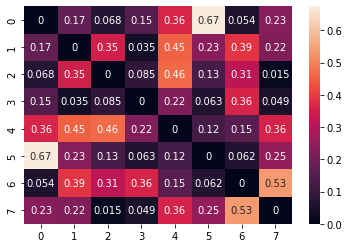

In [122]:
import seaborn as sns
sns.heatmap(confusion, annot=True, linewidths=0)